# Edge Detection
### 1. Sobel and Roberts Filters
### 2. Gaussian Filter
### 3. Laplacian
### 4. Laplacian of Gaussian
### 5. Canny Edge Detection

Helper function to show binary images:

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl

def show_binary_image(image, title=None):

    # Converts from one colour space to the other. this is needed as RGB
    # is not the default colour space for OpenCV

    # Show the image

    plt.imshow(image, cmap=plt.cm.gray)
    # plt.imshow(image)
    

    # remove the axis / ticks for a clean looking image
    plt.xticks([])
    plt.yticks([])

    # if a title is provided, show it
    if title is not None:
        plt.title(title)

    plt.show()

In [2]:
# Imports
import skimage
import scipy
from matplotlib import pyplot as plt
import numpy as np

Import images. We extract only the green channel because it accentuates the difference between edges and background the most. This is common practice in edge detection

In [3]:
# Read image
shakey = skimage.io.imread('images/shakey.jpg')[:,:,1] #skimage is sci-kit ML library for image processing tasks. 
#skimage is the library, io (input, output) is the class we are using, and imread() (image read) is the class method. 
#It's retrieving the image from the specified location in the repo.
#A color image is a 3D object. X and Y axis are the pixels, the Z axis corresponds to the RGB channel. 
#imread converts an image into a numpy array (either 2D or 3D). I imagine there is a corresponding function in PyTorch that converts it into a torch.tensor. 

demon = skimage.io.imread('images/demon.png')[:,:,1] #Extract the Green
demon_girl = skimage.io.imread('images/demon_girl.png')[:,:,1] #Extract the Green
noisy_taj = skimage.io.imread('images/taj-rgb-noise.jpg')[:,:,1]

shakey = noisy_taj


# Gaussian Kernel 

Define the guassian kernel. This method utilizes vectorization for efficiency. 

In [4]:

# Function to create a Gaussian kernel
def gaussian_kernel(size, sigma=1.0):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g / np.sum(g)

g = gaussian_kernel(3, 1)

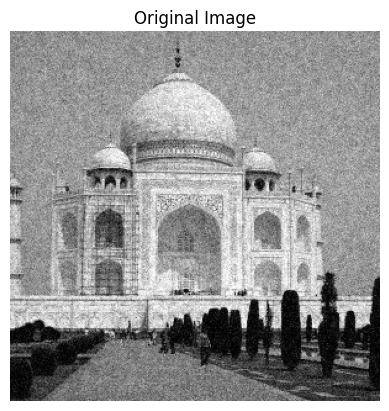

Raw values [[134 124 147 ... 127 109 135]
 [136 148 117 ... 135 133 152]
 [125 146 150 ... 123 128 174]
 ...
 [  8  15  20 ...  51  62  40]
 [ 18  35  40 ...  43  58  32]
 [ 34  57  60 ...  64  85  64]]


In [5]:
# Display the image
plt.imshow(shakey, cmap="gray")
# plt.imshow(shakey)

plt.title("Original Image")
plt.axis('off')
plt.show()
print("Raw values", shakey)

# Sobel Operator 

Define the sobel operator which consists of two distinct kernels--one for the edges on the x-axis and one for the edges on the y-axis. They effectively compute the gradient of the pixels with respect to x and with respect to y.

In [6]:
sobel_x = np.array([[1, 0, -1],
                    [2, 0, -2],
                    [1, 0, -1]])

sobel_y = sobel_x.T #The sobel_y operator is the transpose of sobel_x and vice versa

Since operator_x returns the gradients of the pixels with respect to x and operator_y returns the gradients of the picels with respect to y, we can compute the magnitudes of these gradients in one of two ways:

(1) | x_grads | + | y_grads |: This way is more computationally efficient, but less accurate. It will result in noisy magnitudes, but is suitable for real time applications.

(2) Euclidean norm: This way is more accurate and results in a less noisy magnitude image, but is more computationally expensive. 

In [7]:
def calculate_magnitude(x_kernel, y_kernel):
    return  np.abs(x_kernel) + np.abs(y_kernel) 

def calculate_magnitude2(x_kernel, y_kernel):
    return np.sqrt(x_kernel**2 + y_kernel**2)


We first compute the x_grads and y_grads by convolving the x and y operators with the image independently. 

We then compute the magnitude image by computing the magnitudes for each individual pixel using one of the methods above. 

We then turn that magnitude image into a binary image by threshold it. Specifically, binary_image = magnitude_image > threshold

We then use our helper function to display the image. 

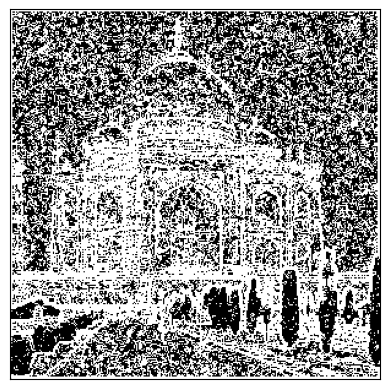

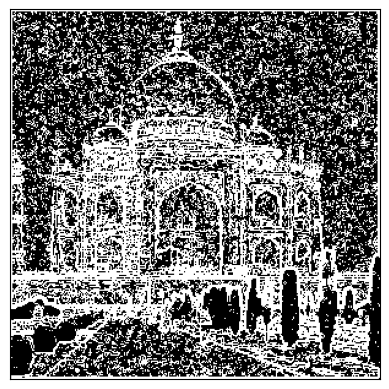

In [8]:

threshold_sobel_x = abs(scipy.signal.convolve2d(shakey, sobel_x))
threshold_sobel_y = abs(scipy.signal.convolve2d(shakey, sobel_y))

#These are magnitude images.
magnitude = calculate_magnitude(threshold_sobel_x, threshold_sobel_y)
magnitude2 = calculate_magnitude2(threshold_sobel_x, threshold_sobel_y)

#Converts magnitude images to binary images and then displays them with the helper function
show_binary_image(magnitude>100)
show_binary_image(magnitude2>100)


It is best practice to apply the gaussian filter to the image beforehand. As you can see, the edge detection is meaningfully improved when we smooth out noise. 

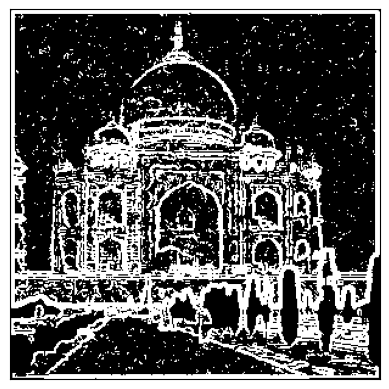

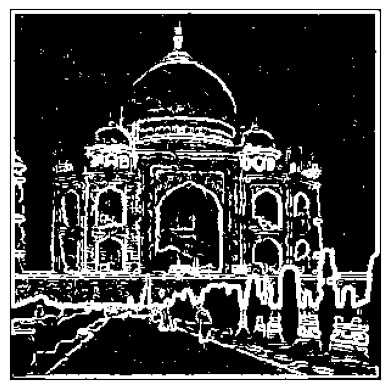

In [9]:
smoothed_image = abs(scipy.signal.convolve2d(shakey, g))
threshold_sobel_x = abs(scipy.signal.convolve2d(smoothed_image, sobel_x))
threshold_sobel_y = abs(scipy.signal.convolve2d(smoothed_image, sobel_y))
magnitude = calculate_magnitude(threshold_sobel_x, threshold_sobel_y)
magnitude2 = calculate_magnitude2(threshold_sobel_x, threshold_sobel_y)

# magnitude

show_binary_image(magnitude>100)
show_binary_image(magnitude2>100)


# Roberts Operator

Repeat the above for the roberts operator.

In [10]:
roberts_x = np.array([[1, 0],
                     [0, -1]])

roberts_y = np.sort(roberts_x, axis=1)

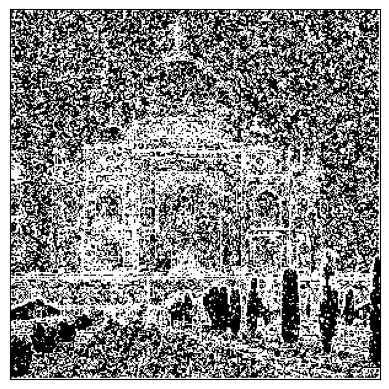

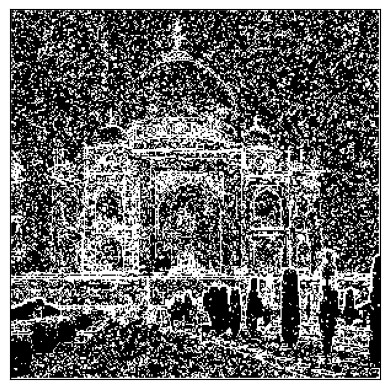

In [11]:

threshold_roberts_x = abs(scipy.signal.convolve2d(shakey, roberts_x))
threshold_roberts_y = abs(scipy.signal.convolve2d(shakey, roberts_y))
magnitude = calculate_magnitude(threshold_roberts_x, threshold_roberts_y)
magnitude2 = calculate_magnitude2(threshold_roberts_x, threshold_roberts_y)

# magnitude

show_binary_image(magnitude>40)
show_binary_image(magnitude2>40)


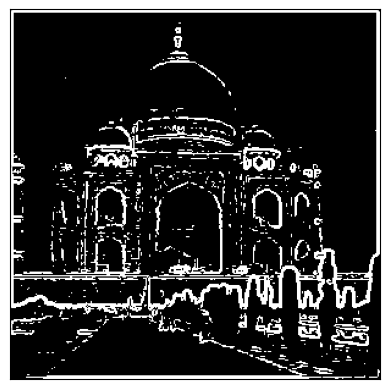

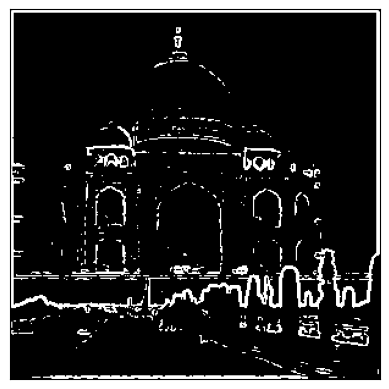

In [12]:

smoothed_image = abs(scipy.signal.convolve2d(shakey, g))
threshold_roberts_x = abs(scipy.signal.convolve2d(smoothed_image, roberts_x))
threshold_roberts_y = abs(scipy.signal.convolve2d(smoothed_image, roberts_y))
magnitude = calculate_magnitude(threshold_roberts_x, threshold_roberts_y)
magnitude2 = calculate_magnitude2(threshold_roberts_x, threshold_roberts_y)

# magnitude

show_binary_image(magnitude>40)
show_binary_image(magnitude2>40)


# Laplacian and Laplacian of Gaussian

In [13]:
def zero_crossing(log_image, threshold=0.1):
    """
    Detect zero crossings in an LoG filtered image.
    A zero crossing occurs if the sign of the value of a pixel's neighbor is different,
    and the magnitude is above a certain threshold.
    """
    log_image = np.pad(log_image, pad_width=1, mode='constant', constant_values=0)

    # Initialize the edge image
    edges = np.zeros_like(log_image)
    # Get the dimensions of the LoG image
    n, m = log_image.shape

    # Iterate over the image (excluding the borders, assumes zero-padding)
    for x in range(1, n-1):
        for y in range(1, m-1):
            # Get the neighborhood of the pixel
            patch = log_image[x-1:x+2, y-1:y+2]
            # Find the maximum and minimum
            pmax, pmin = patch.max(), patch.min()
            # Check if it crosses zero and if the magnitude is above the threshold
            if pmax > threshold and pmin < -threshold:
                # Mark as edge
                edges[x, y] = 1
    return edges


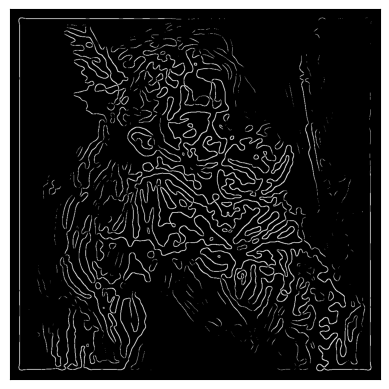

In [14]:
import cv2
# image = cv2.imread('images/shakey.jpg', cv2.IMREAD_GRAYSCALE)
# image = cv2.imread('images/taj-rgb-noise.jpg', cv2.IMREAD_GRAYSCALE)
image = cv2.imread('images/demon_girl.png', cv2.IMREAD_GRAYSCALE)

# Validate if the image was properly loaded
if image is None:
    print("Error: Image not found.")
else:
    # Create a Gaussian kernel
    gaussian_kernel_size = 53
    gaussian_sigma = 7
    g = gaussian_kernel(gaussian_kernel_size, gaussian_sigma)

    # Apply the Laplacian operator
    
    laplacian_kernel = np.array([[-1,-1,-1],
                      [-1, 8, -1],
                      [-1,-1,-1]])


    # Gaussian then Laplacian (Regular Laplacian approach)
    smoothed_image = scipy.signal.convolve2d(image, g)    
    laplacian_image = scipy.signal.convolve2d(smoothed_image, laplacian_kernel)
    

    # # Find zero-crossings
    edges = zero_crossing(laplacian_image, .03)

    # # Display the edge image
    show_binary_image(edges)

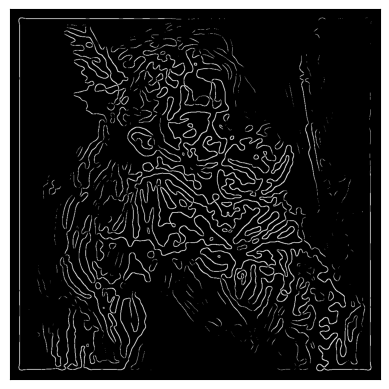

In [15]:
# image = cv2.imread('images/shakey.jpg', cv2.IMREAD_GRAYSCALE)
# image = cv2.imread('images/taj-rgb-noise.jpg', cv2.IMREAD_GRAYSCALE)
image = cv2.imread('images/demon_girl.png', cv2.IMREAD_GRAYSCALE)

# Validate if the image was properly loaded
if image is None:
    print("Error: Image not found.")
else:
    # Create a Gaussian kernel
    gaussian_kernel_size = 53
    gaussian_sigma = 7
    g = gaussian_kernel(gaussian_kernel_size, gaussian_sigma)

    # Apply the Laplacian operator
    
    laplacian_kernel = np.array([[-1,-1,-1],
                      [-1, 8, -1],
                      [-1,-1,-1]])

    
    #Laplacian of Gaussian (LoG)
    LoG = scipy.signal.convolve2d(g, laplacian_kernel)
    laplacian_image = scipy.signal.convolve2d(image, LoG) #Larger matrix on the left. 

    # # Find zero-crossings
    edges = zero_crossing(laplacian_image, .03)

    # # Display the edge image
    show_binary_image(edges)

# Canny Edge Detection

In [16]:
# image = cv2.imread('images/shakey.jpg', cv2.IMREAD_GRAYSCALE)
image = cv2.imread('images/taj-rgb-noise.jpg', cv2.IMREAD_GRAYSCALE)
# image = cv2.imread('images/demon_girl.png', cv2.IMREAD_GRAYSCALE)
image = np.pad(image, pad_width=1, mode='constant', constant_values=0) #Zero padding

#Smooth the image
g = gaussian_kernel(5, 2)
smoothed_image = scipy.signal.convolve2d(image, g)

In [17]:
def magnitude_img(G_x, G_y):
    return np.sqrt(G_x**2 + G_y**2)

def direction_img(G_x, G_y):
    return np.arctan2(G_y, G_x) * (180 / np.pi) #We return it in degrees so that it's easier to discretize the direction image. 

def non_maximum_suppression(magnitude, direction):
    # Create an output image initialized to zero (same size as magnitude image)
    
    suppressed = np.zeros_like(magnitude) #Initally, everything is suppressed. 
    
    
    # Iterate over each pixel in the image (excluding the border pixels)
    for x in range(1, magnitude.shape[0] - 1):
        for y in range(1, magnitude.shape[1] - 1):
            # Get the direction of the current pixel
            
            
            angle = direction[x, y] % 180  # Ensure the angle is within [0, 180)
            
            # Determine the neighbors based on the direction
            if 0 <= angle < 22.5 or 157.5 <= angle <= 180:
                neighbor1 = magnitude[x, y-1]
                neighbor2 = magnitude[x, y+1]
            elif 22.5 <= angle < 67.5:
                neighbor1 = magnitude[x-1, y+1]
                neighbor2 = magnitude[x+1, y-1]
            elif 67.5 <= angle < 112.5:
                neighbor1 = magnitude[x-1, y]
                neighbor2 = magnitude[x+1, y]
            else:  # 112.5 <= angle < 157.5
                neighbor1 = magnitude[x-1, y-1]
                neighbor2 = magnitude[x+1, y+1]
            
            # Suppress non-maximum pixels
            if magnitude[x, y] >= neighbor1 and magnitude[x, y] >= neighbor2:
                suppressed[x, y] = magnitude[x, y]
    
    return suppressed


def double_thresholding(edge_magnitude, low_threshold, high_threshold):
        # Initialize matrices to identify strong, weak, and non-edges
    strong_edges = (edge_magnitude >= high_threshold)
    weak_edges = (edge_magnitude >= low_threshold) & (edge_magnitude < high_threshold)
    
    # Mark strong edges with a unique value (e.g., 255), weak edges with another (e.g., 100), and suppress non-edges (set to 0)
    output = np.zeros_like(edge_magnitude, dtype=np.uint8)
    output[strong_edges] = 255  # Strong edges
    output[weak_edges] = 100  # Weak edges
    
    # Non-edges remain zero as initialized
    return output

from scipy.ndimage import label


def hysteresis(thresholded_edges, weak_value=100, strong_value=255):
        # Label connected components of strong edges
    labeled_array, num_features = label(thresholded_edges == strong_value)
    
    # Find indices of weak edges
    weak_indices = np.where(thresholded_edges == weak_value)
    # Initialize output image
    output = np.zeros_like(thresholded_edges, dtype=np.uint8)
    
    # Check each weak edge to see if it's connected to a strong edge
    for i in range(len(weak_indices[0])):
        x, y = weak_indices[0][i], weak_indices[1][i]
        
        # Check neighbors for a label, indicating connection to a strong edge
        if labeled_array[max(0, x-1):x+2, max(0, y-1):y+2].any():
            output[x, y] = strong_value
    
    # Copy over the strong edges to the output
    output[thresholded_edges == strong_value] = strong_value
    
    return output

def canny_edge_detector(smoothed_image, low_threshold, high_threshold):
    
    #First, we get the gradients of the pixels in the intensity image by applying the Sobel operator. 
    G_x = scipy.signal.convolve2d(smoothed_image, sobel_x)
    G_y = scipy.signal.convolve2d(smoothed_image, sobel_y)

    #We get the magnitude and direction images
    magnitude_image = magnitude_img(G_x, G_y)
    direction_image = direction_img(G_x, G_y) 
     
    #Apply non-max suppression using the magnitude and direction images
    magnitude_image = non_maximum_suppression(magnitude_image, direction_image)
    
    #Once we've applied non_max suppression, we identify strong, weak, and non-edges with double thresholding
    edge_image = double_thresholding(magnitude_image, low_threshold, high_threshold)
    
    #Finally, we do edge linking with hysterisis on the edge_image to determine which weak edges to suppress. They're suppressed if not connected to a strong edge. 
    return hysteresis(edge_image)
    

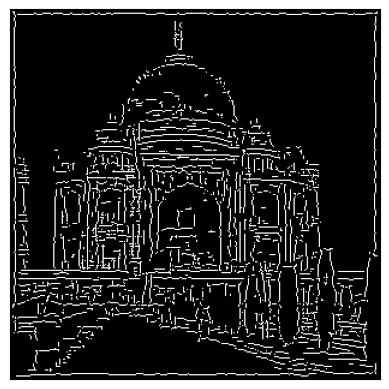

In [18]:
import sys

# Set printing options to display the entire array
np.set_printoptions(threshold=sys.maxsize)
canny_edge_image = canny_edge_detector(smoothed_image, 25, 50)
show_binary_image(canny_edge_image)

### Canny Edge Detector OpenCV Implementation

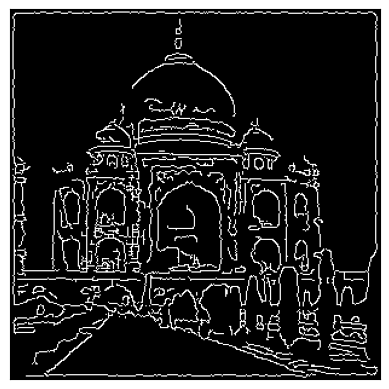

In [19]:
smoothed_image_uint8 = np.uint8(smoothed_image)
edges = cv2.Canny(smoothed_image_uint8, threshold1=50, threshold2=100)
show_binary_image(edges)


# Lab 2

In [20]:
import numpy as np

sobel_x = np.array([
    [-1,0,1],
    [-2,0,2],
    [-1,0,1]
])

sobel_y = np.array([
    [1,2,1],
    [0,0,0],
    [-1,-2,-1]
])

difference_gradient_filter_x = np.array([
    [-1,1],
    [-1,1]
])

difference_gradient_filter_y = np.array([
    [1,1],
    [-1,-1]
])

first_order_gaussian_filter_1d_length5 = np.array([
    [0.1897,0.1741,0,-0.1741,-0.1897]
])

gaussian_filter_1d_length5 = np.array([
    [0.0545,0.2442,0.4026,0.2442,0.0545]
])

gaussian_filter_3x3 = np.array([
    [0.0113,0.0838,0.0113],
    [0.0838,0.6193,0.0838],
    [0.0113,0.0838,0.0113]
])

gaussian_filter_5x5 = np.array([
 [0.00297025, 0.0133089,  0.0219417,  0.0133089,  0.00297025],
 [0.0133089,  0.05963364, 0.09831492, 0.05963364, 0.0133089 ],
 [0.0219417,  0.09831492, 0.16208676, 0.09831492, 0.0219417 ],
 [0.0133089,  0.05963364, 0.09831492, 0.05963364, 0.0133089 ],
 [0.00297025, 0.0133089,  0.0219417,  0.0133089 , 0.00297025]
])

In [21]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import math

def show_rgb_image(image, title=None):
    # Converts from one colour space to the other. this is needed as RGB
    # is not the default colour space for OpenCV

    mpl.rcParams['figure.dpi'] =  300


    # Show the image
    plt.imshow(image)

    # remove the axis / ticks for a clean looking image
    plt.xticks([])
    plt.yticks([])

    # if a title is provided, show it
    if title is not None:
        plt.title(title)

    plt.show()

def show_binary_image(image, title=None):
    # Converts from one colour space to the other. this is needed as RGB
    # is not the default colour space for OpenCV

    # Show the image

    plt.imshow(image, cmap=plt.cm.gray)

    # remove the axis / ticks for a clean looking image
    plt.xticks([])
    plt.yticks([])

    # if a title is provided, show it
    if title is not None:
        plt.title(title)

    plt.show()


# Gives the Probability Density Function (pdf) of the Normal 
# Distribution with mean, Standard Deviation (sd) std_dev, for the value x.
# example: sample_gaussian(0.1,0,np.arange(-3,4,1,dtype=np.float32)));
# Calculates pdf with mean = 0, sd = 0.1, for a vector of 7 elements long
def sample_gaussian(std_dev,mean,vec):

    x= -np.square(vec-float(mean))/(2.0*math.pow(std_dev,2))
    
    return np.array([1/(std_dev * math.sqrt(2* math.pi))  * np.exp(x)])


def zero_cross(image):
    z_c_image = np.zeros(image.shape)
    thresh = np.absolute(image).mean() * 0.75
    h,w = image.shape
    for y in range(1, h - 1):
        for x in range(1, w - 1):
            patch = image[y-1:y+2, x-1:x+2]
            p = image[y, x]
            maxP = patch.max()
            minP = patch.min()
            if (p > 0):
                zeroCross = True if minP < 0 else False
            else:
                zeroCross = True if maxP > 0 else False
            if ((maxP - minP) > thresh) and zeroCross:
                z_c_image[y, x] = 1
    return z_c_image


def magnitude_im(operator_x, operator_y, image):
    G_x = scipy.signal.convolve2d(image, operator_x)
    G_y = scipy.signal.convolve2d(image, operator_y)
    mag_img = np.sqrt(G_x**2 + G_y**2)
    return mag_img


def gaussian_filter(size, sigma=1.0):
    size = int(size) // 2
    normal = 1 / (2 * np.pi * sigma**2)
    x, y = np.mgrid[-size:size+1,-size:size+1]
    g = np.exp(-((x**2 + y**2) / (2 * sigma**2))) * normal
    return g / np.sum(g)

def one_d_gaussian_filter(size, sigma=1.0):
    x = np.arange(-size, size+1)
    normal = 1 / (np.sqrt(2 * np.pi * sigma**2))
    g = np.exp(- (x**2 / (2 * sigma**2))) * normal
    return g / np.sum(g)

        

In [22]:
# Imports
import skimage
import scipy
import time
from matplotlib import pyplot as plt
import numpy as np

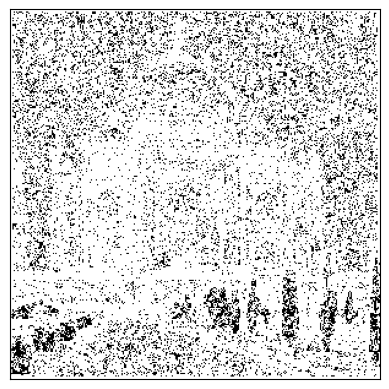

In [23]:
image = cv2.imread("images/taj-rgb-noise.jpg", cv2.IMREAD_GRAYSCALE)
magnitude_image = magnitude_im(sobel_x, sobel_y, image)
show_binary_image(magnitude_image > 40)

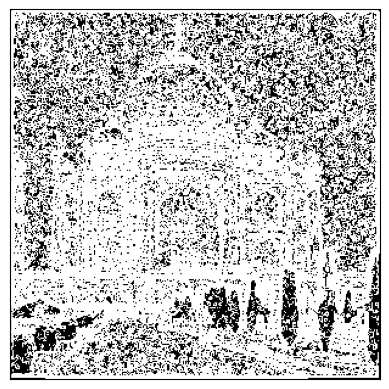

In [24]:
smoothed_image = scipy.signal.convolve2d(image, gaussian_filter_3x3)
magnitude_image = magnitude_im(sobel_x, sobel_y, smoothed_image)
show_binary_image(magnitude_image > 40)

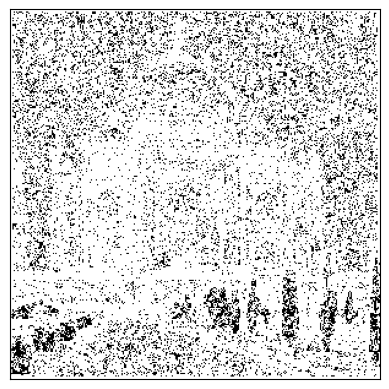

In [25]:
smoothed_image = scipy.signal.convolve2d(image, gaussian_filter_5x5)
magnitude_image = magnitude_im(sobel_x, sobel_y, image)
show_binary_image(magnitude_image > 40)

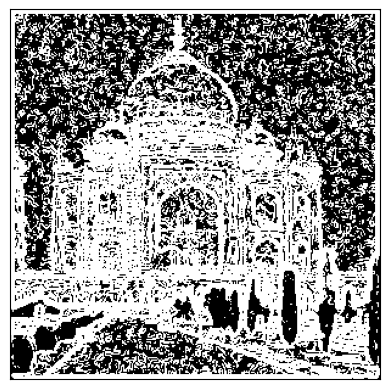

In [26]:
best_gaussian_lmao = gaussian_filter(3, 1) #3x3
smoothed_image = scipy.signal.convolve2d(image, best_gaussian_lmao)
magnitude_image = magnitude_im(sobel_x, sobel_y, smoothed_image)
show_binary_image(magnitude_image > 40)

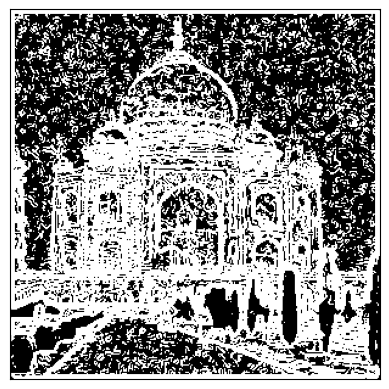

In [27]:
best_gaussian_lmao = gaussian_filter(3, 2) #3x3
smoothed_image = scipy.signal.convolve2d(image, best_gaussian_lmao)
magnitude_image = magnitude_im(sobel_x, sobel_y, smoothed_image)
show_binary_image(magnitude_image > 40)

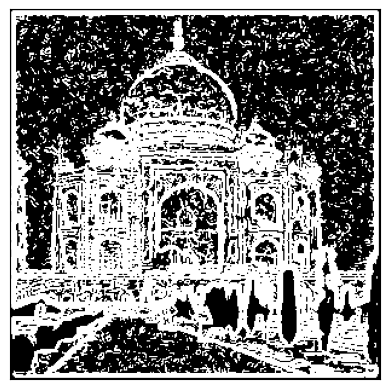

In [28]:
best_gaussian_lmao = gaussian_filter(5, 1) #5x5
smoothed_image = scipy.signal.convolve2d(image, best_gaussian_lmao)
magnitude_image = magnitude_im(sobel_x, sobel_y, smoothed_image)
show_binary_image(magnitude_image > 40)

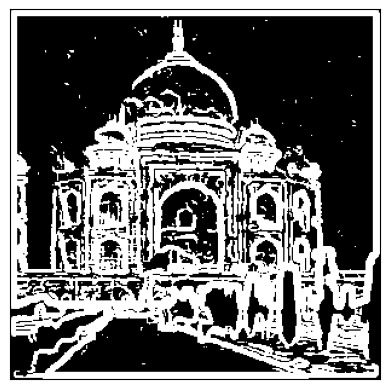

In [29]:
best_gaussian_lmao = gaussian_filter(5, 2) #5x5
smoothed_image = scipy.signal.convolve2d(image, best_gaussian_lmao)
magnitude_image = magnitude_im(sobel_x, sobel_y, smoothed_image)
show_binary_image(magnitude_image > 40)

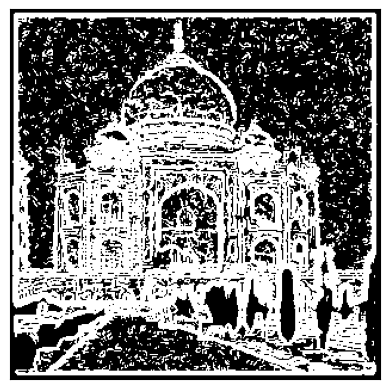

In [30]:
best_gaussian_lmao = gaussian_filter(9, 1) #9x9
smoothed_image = scipy.signal.convolve2d(image, best_gaussian_lmao)
magnitude_image = magnitude_im(sobel_x, sobel_y, smoothed_image)
show_binary_image(magnitude_image > 40)

Run time was 0.021783828735351562


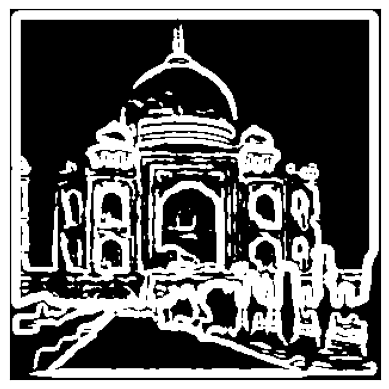

In [31]:
start_time = time.time()
best_gaussian_lmao = gaussian_filter(9, 2) #9x9
smoothed_image = scipy.signal.convolve2d(image, best_gaussian_lmao)
magnitude_image = magnitude_im(sobel_x, sobel_y, smoothed_image)
end_time = time.time()
run_time = end_time - start_time
print(f"Run time was {run_time}")
show_binary_image(magnitude_image > 40)

Run time was 0.006432771682739258


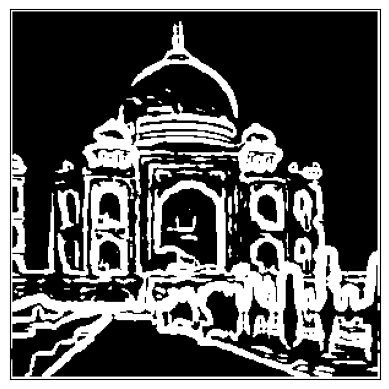

In [32]:
import time 
start_time = time.time()
one_d = one_d_gaussian_filter(9, 2)
smoothed_image = scipy.ndimage.convolve1d(image, one_d, axis=0) #Vertical, across columns
smoothed_image = scipy.ndimage.convolve1d(smoothed_image, one_d, axis=1) #Horizontal, accross rows 
magnitude_image = magnitude_im(sobel_x, sobel_y, smoothed_image)
end_time = time.time()
run_time = end_time - start_time
print(f"Run time was {run_time}")
show_binary_image(magnitude_image > 40)

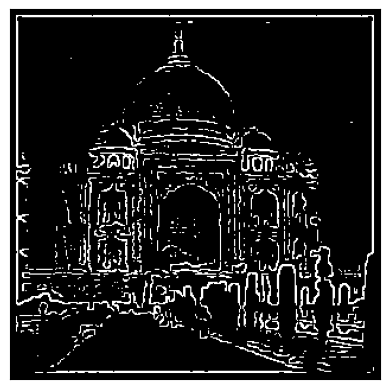

In [33]:
laplacian_kernel = np.array([[-1,-1,-1],
                      [-1, 8, -1],
                      [-1,-1,-1]])
best_gaussian_lmao = gaussian_filter(9, 2)
smoothed_image = scipy.signal.convolve2d(image, best_gaussian_lmao)
laplacian = scipy.signal.convolve2d(smoothed_image, laplacian_kernel)
laplacian_image = zero_crossing(laplacian, threshold=6.5)

show_binary_image(laplacian_image)

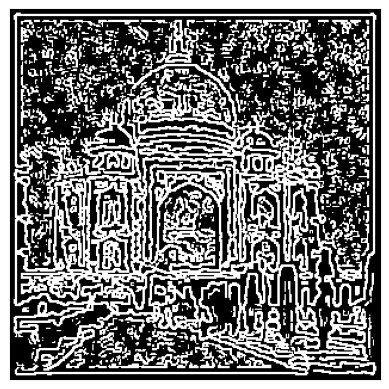

In [34]:
laplacian_kernel = np.array([[-1,-1,-1],
                      [-1, 8, -1],
                      [-1,-1,-1]])
best_gaussian_lmao = gaussian_filter(9, 2)
smoothed_image = scipy.signal.convolve2d(image, best_gaussian_lmao)
laplacian = scipy.signal.convolve2d(smoothed_image, laplacian_kernel)
laplacian_image = zero_cross(laplacian)
show_binary_image(laplacian_image)

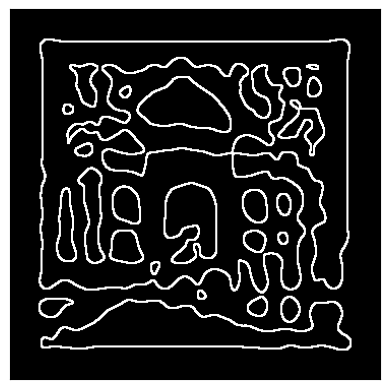

In [35]:
laplacian_kernel = np.array([[-1,-1,-1],
                      [-1, 8, -1],
                      [-1,-1,-1]])
best_gaussian_lmao = gaussian_filter(9, 2)
LoG = scipy.signal.convolve2d(best_gaussian_lmao, LoG)
laplacian = scipy.signal.convolve2d(image, LoG)
laplacian_image = zero_crossing(laplacian, threshold=0.00001)

show_binary_image(laplacian_image)

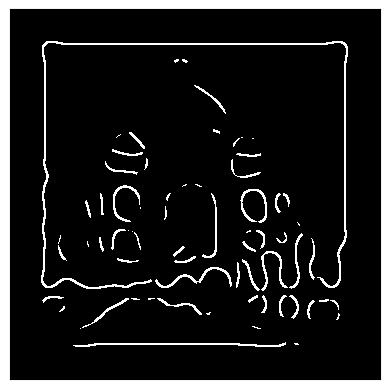

In [36]:
laplacian_kernel = np.array([[-1,-1,-1],
                      [-1, 8, -1],
                      [-1,-1,-1]])
best_gaussian_lmao = gaussian_filter(9, 2)
LoG = scipy.signal.convolve2d(best_gaussian_lmao, LoG)
laplacian = scipy.signal.convolve2d(image, LoG)
laplacian_image = zero_cross(laplacian)

show_binary_image(laplacian_image)

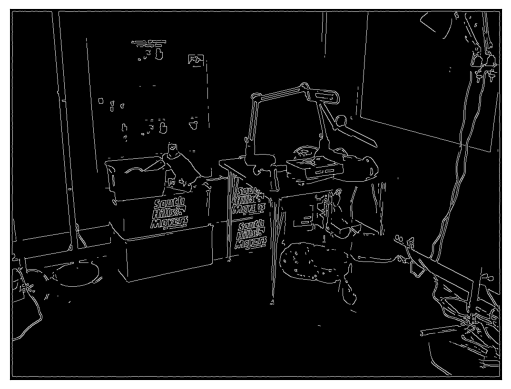

In [66]:

image = cv2.imread("images/cluttera2.jpg", cv2.IMREAD_GRAYSCALE)
gauss = gaussian_filter(9, 1)
smoothed_image = scipy.signal.convolve2d(image, gauss)
# Set printing options to display the entire array
np.set_printoptions(threshold=sys.maxsize)
img_edges = canny_edge_detector(smoothed_image, 50, 100)
show_binary_image(img_edges)

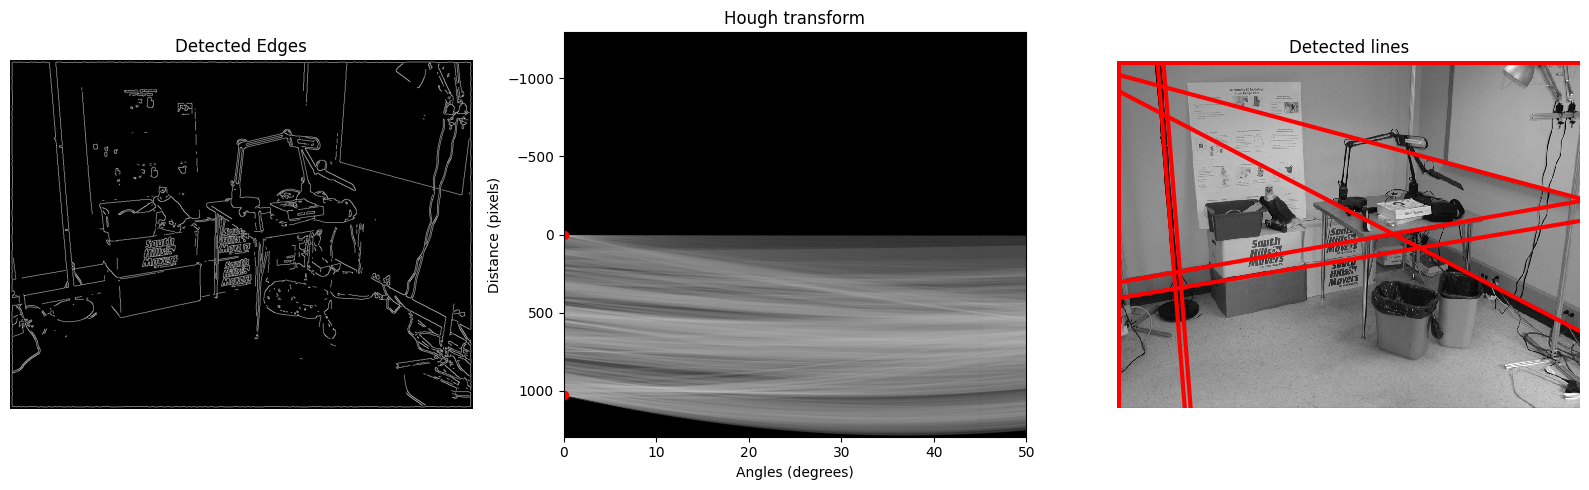

In [67]:
from skimage import io
from matplotlib import pyplot as plt
import numpy as np
from skimage.transform import hough_line, hough_line_peaks
from skimage.color import rgb2gray
from skimage.feature import canny
from matplotlib import cm

# Configure the figure
fig, axes = plt.subplots(1, 3,figsize=(16, 5))
ax = axes.ravel()

ax[0].imshow(img_edges, cmap=cm.gray)
ax[0].set_title('Detected Edges')
ax[0].set_axis_off()

# Classic straight-line Hough transform
tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
h, theta, d = hough_line(img_edges, theta=tested_angles)

accum, angles, dists = hough_line_peaks(h,theta,d,threshold=1,num_peaks=10)

angle_step = 0.5 * np.diff(theta).mean()
d_step = 0.5 * np.diff(d).mean()
bounds = [np.rad2deg(theta[0] - angle_step),
          np.rad2deg(theta[-1] + angle_step),
          d[-1] + d_step, d[0] - d_step]

# Plot each of the lines on the hough transform
for i in range(0,len(angles)):
    ax[1].plot(np.rad2deg(angles[i]),dists[i],'ro')

ax[1].imshow(np.log(1 + h), extent=bounds, cmap=cm.gray,aspect=0.1)

ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')

ax[1].axis('auto')
ax[1].set_xlim(0,50)

# Plot Figure 3: Detected Lines
for i in range(0,len(angles)):
    (x0, y0) = dists[i] * np.array([np.cos(angles[i]), np.sin(angles[i])])
    ax[2].axline((x0, y0),slope=np.tan(angles[i] + np.pi/2), color="red", linewidth=3)

ax[2].set_ylim((image.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines')

io.imshow(image)
plt.show()